In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Problem Statement

Suppose you have a pair of fair dice each with $n$ sides, numbered 1 through $n$. Consider the distribution of the sum of the dice rolls. Are there any other pairs of dice each with $n$ sides that have the same distribution (using only positive integers for the dice faces)?  Consider only the cases $n = 4, 6, 8$.

# Approach and Solution

## Part 1: Investigating the Problem; Can we use Monte Carlo?
Is it feasible to do Monte Carlo simulations to create the right dice?

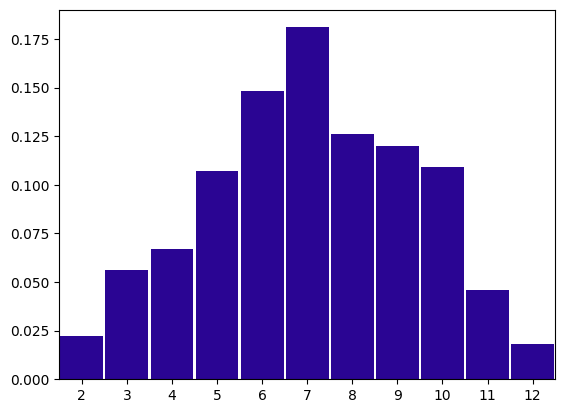

In [2]:
# Set the seed to any value to create a consistent notebook
#rand.seed(12333)

plasma = colormaps['plasma']

# For dice with the following faces,
die_1 = np.array([1, 2, 3, 4, 5, 6])
die_2 = np.array([1, 2, 3, 4, 5, 6])

"""
Rolls each die specified in dice and returns the sum of the faces.
"""
def sum_dice(dice):
  return sum(rand.choice(die) for die in dice)

N = 1000
results = np.zeros((N, 1))

# Roll the dice N times and store the sums
for i in range(N):
  results[i] = sum_dice([die_1, die_2])


fig, ax = plt.subplots()

# Visualize the sum as a bar chart
buffer = 1 / 2
vals, frq = np.unique(results, return_counts=True)
ax.bar(vals, frq / np.sum(frq), width=0.95, color=plasma(0.05))
ax.set_xlim(np.min(vals) - buffer, np.max(vals) + buffer)
ax.set_xticks(range(np.min(vals.astype(int)), np.max(vals.astype(int))+1))
pass

We can see that with a naive experiment (perhaps using too few samples as above, you can try rerunning the cell for increasing ```N``` until you obtain a consistent result), it may be difficult to use the experimental distribution to compare sets of dice.

The sum of the Cartesian product (which I will call the Cartesian sum) has an interesting property for 2 dice (below I give examples for 2 six sided die, then 2 8 sided die).

In [3]:
from funcs import cartesian_sum

# For dice with the following side numbers
# Assuming standard dice (a 4 sided die has faces [1,2,3,4], etc.)
for i in 4, 6, 8:
  print(cartesian_sum(2*[range(1, i+1)]).reshape(i, i))

[[2 3 4 5]
 [3 4 5 6]
 [4 5 6 7]
 [5 6 7 8]]
[[ 2  3  4  5  6  7]
 [ 3  4  5  6  7  8]
 [ 4  5  6  7  8  9]
 [ 5  6  7  8  9 10]
 [ 6  7  8  9 10 11]
 [ 7  8  9 10 11 12]]
[[ 2  3  4  5  6  7  8  9]
 [ 3  4  5  6  7  8  9 10]
 [ 4  5  6  7  8  9 10 11]
 [ 5  6  7  8  9 10 11 12]
 [ 6  7  8  9 10 11 12 13]
 [ 7  8  9 10 11 12 13 14]
 [ 8  9 10 11 12 13 14 15]
 [ 9 10 11 12 13 14 15 16]]


Notice the beautiful symmetry. For 2 identical dice with $n$ sides, the sum of their outcomes follows a simple tabular pattern: one 2, two 3s, three 4s, ..., $n$ lots of $n+1$, then decreasing again! Or as a generalized table,

| sum             | 2 | 3 | 4 | 5 | $\cdots$ | $n + 1$ | $n + 2$ | $\cdots$ | $2n$ |
| ---             |---|---|---|---| ---      | ---     | ---     | ---      | ---  |
| representations | 1 | 2 | 3 | 4 | $\cdots$ | $n$     | $n - 1$ | $\cdots$ | 1    |

This is similar to the pattern shown in the video.

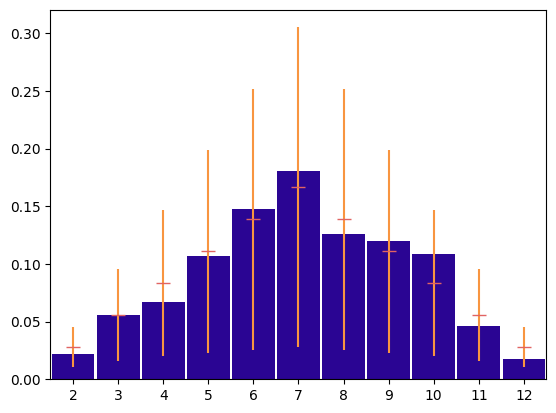

In [4]:
# The expected distribution is outlined in red
# The variance is outlined in orange,
# since it follows a multinomial distribution 
# (since we can enumerate all of equiprobable outcomes)

# The form of the variance for the multinomial is
# Var(X_i) = n p_i(1 - p_i)
# n is the number of trials
# p_i is the probablitity of the ith sum
n = 6
target = np.sort(cartesian_sum(2*[range(1, n+1)]))
vals, frq = np.unique(target, return_counts=True)
p_i = frq / np.power(n, 2)
std = np.sqrt(vals.shape[0] * p_i * (1 - p_i))

# Wilson confidence for binomials
# I use a Wilson score to approximate the multinomial confidence interval.
# Although there should be some adjustment for multiple comparison (which is not done here)
# https://stackoverflow.com/questions/10029588/python-implementation-of-the-wilson-score-interval
def confidence(phat, z):
  #z = 1.96 #1.44 = 85%, 1.96 = 95%
  return ((phat + z*z/(2*N) - z * np.sqrt((phat*(1-phat)+z*z/(4*N))/N))/(1+z*z/N))

ax.errorbar(x=vals,
            y=frq / np.sum(frq), # The expecation of the multinomial
            yerr=confidence(p_i, 2.576),
            marker='_',
            linestyle='',
            markersize=10,
            markeredgecolor=plasma(0.6),
            markerfacecolor=plasma(0.6),
            c=plasma(0.75)
            )
fig

## Part 2: Analytic Approach and Combinations

For two dice with $n$ sides each labelled $x_{jl}$, with $j = 1, 2, \cdots n$ (WLOG assume $x_{jl}$ to be ordered in $j$) and $l = 1, 2$ specifying the identity of the die (as we allow each dice to have different faces), a solution satisfies the following system of $i$ equalities:

$$\#\{(k,\, m)\; |\; x_{k1} + x_{m2} = 2\} = 1$$

$$\#\{(k,\, m)\; |\; x_{k1} + x_{m2} = 3\} = 2$$

$$\vdots$$

$$\#\{(k,\, m)\; |\; x_{k1} + x_{m2} = n + 1\} = n$$

$$\vdots$$

$$\#\{(k,\, m)\; |\; x_{k1} + x_{m2} = 2n\} = 1$$

following the table above, where the notation $\#\{\}$ is used to mean the number of elements (in this case, pairs $(k,\, m)$) in the set. This means in order to do a brute force search, identifying identical distribution is equivalent to ensuring the ordered sum's number of representations is exactly equal to that of the equal, unaltered dice. The pattern becomes, in more formal notation for each $i$:

$$\#\{(k,\, m)\; |\; x_{j1} + x_{k2} = 2i\} = r_i$$

where
$$
r_i =
\begin{cases}
i & \text{ if } i \leq n\\
n - i & \text{ otherwise }
\end{cases}
$$

In other words, for the count of sums below,

$$
s_{i}(x_{j1}, x_{j2}) =
\sum_{k=1}^n \sum_{m=1}^n \mathbf{1}_{x_{k1} + x_{m2} = 2i}
$$

we require $s_i ≡ r_i$, where $\mathbf{1}$ is the indicator function. This is the same system of equalities in $i$, and we should clarify the solution space. The $x_{jl}$ should be positive integers, and clearly will not exceed $2n-1$. Another important fact for reducing the search space is that $x_{1l} \equiv 1$, since we need to be able to roll the minimum.

In [5]:
from funcs import grid_search_dice
import time
# A naive, brute force approach:

grid = zip([4, 4, 6, 6], [False, True, False, True])
results = {}
times = []
times.append(time.time())
for args in grid:
    results[args] = grid_search_dice(args[0], parallel=args[1])
    times.append(time.time())

for i, result in enumerate(results):
    print(f'Grid search for 2 dice of size {result[0]} {'computed in parallel ' if result[1] else ''}took {times[i+1] - times[i]} seconds.')
    print(f'Solutions are: {results[result]}')

Grid search for 2 dice of size 4 took 0.01799750328063965 seconds.
Solutions are: [((1, 2, 2, 3), (1, 3, 3, 5)), ((1, 2, 3, 4), (1, 2, 3, 4))]
Grid search for 2 dice of size 4 computed in parallel took 0.3688788414001465 seconds.
Solutions are: [((1, 2, 2, 3), (1, 3, 3, 5)), ((1, 2, 3, 4), (1, 2, 3, 4))]
Grid search for 2 dice of size 6 took 2.1144063472747803 seconds.
Solutions are: [((1, 2, 2, 3, 3, 4), (1, 3, 4, 5, 6, 8)), ((1, 2, 3, 4, 5, 6), (1, 2, 3, 4, 5, 6))]
Grid search for 2 dice of size 6 computed in parallel took 0.8782117366790771 seconds.
Solutions are: [((1, 2, 2, 3, 3, 4), (1, 3, 4, 5, 6, 8)), ((1, 2, 3, 4, 5, 6), (1, 2, 3, 4, 5, 6))]


## Solution: 

In [6]:
n = 8

start_time = time.time()
result = grid_search_dice(n, parallel=True)
end_time = time.time()

print(f'Grid search for 2 dice of size {n} computed in parallel took {end_time - start_time} seconds.')
print('The following are solutions:')
for dice_set in result:
    print(f'{dice_set}')

Grid search for 2 dice of size 8 computed in parallel took 263.2604787349701 seconds.
The following are solutions:
((1, 2, 2, 3, 3, 4, 4, 5), (1, 3, 5, 5, 7, 7, 9, 11))
((1, 2, 2, 3, 5, 6, 6, 7), (1, 3, 3, 5, 5, 7, 7, 9))
((1, 2, 3, 3, 4, 4, 5, 6), (1, 2, 5, 5, 6, 6, 9, 10))
((1, 2, 3, 4, 5, 6, 7, 8), (1, 2, 3, 4, 5, 6, 7, 8))


So the solutions are:

1: (1, 2, 2, 3, 3, 4, 4, 5), (1, 3, 5, 5, 7, 7, 9, 11) 

2: (1, 2, 2, 3, 5, 6, 6, 7), (1, 3, 3, 5, 5, 7, 7, 9) 

3: (1, 2, 3, 3, 4, 4, 5, 6), (1, 2, 5, 5, 6, 6, 9, 10) 

4: (1, 2, 3, 4, 5, 6, 7, 8), (1, 2, 3, 4, 5, 6, 7, 8)

Turns out we had to use parallel processing to speed the computation up! The approximate size of search space for two dice of size 8 is computed in the next cell, and several tricks were used to cut the space down in the grid search.

In [7]:
for i in [4, 6, 8]:
    N = (i ** i) ** 2
    print(f'For 2 {i}-sided die, the search space could be as large as {N:,} sets of dice.')

For 2 4-sided die, the search space could be as large as 65,536 sets of dice.
For 2 6-sided die, the search space could be as large as 2,176,782,336 sets of dice.
For 2 8-sided die, the search space could be as large as 281,474,976,710,656 sets of dice.


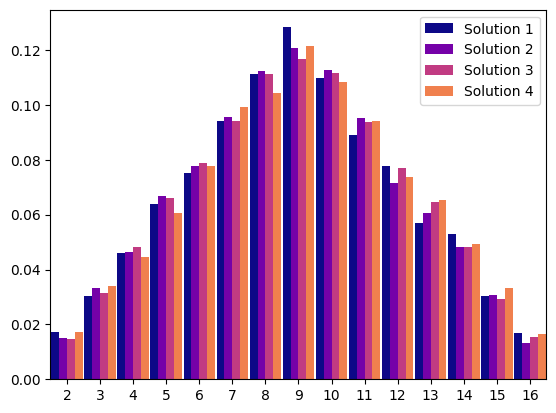

In [8]:
# Do these result in the same final distribution?
n = 8
dice_sets = [dice_set for dice_set in result]
N = 10000

roll_sums = np.zeros((N, len(dice_sets)))


for i in range(N):
    for j, dice_set in enumerate(dice_sets):
        roll_sums[i][j] = sum_dice(dice_set)


fig, ax = plt.subplots()

# Visualize the sum as a bar chart
buffer = 1 / 2
hists = np.zeros((len(dice_sets), 2 * n - 1))

for i, col in enumerate(roll_sums.T):
    vals, frq = np.unique(col, return_counts=True, axis=0)
    hists[i, ] = frq

norm_hists = hists / np.sum(hists, axis=1).reshape(-1, 1)
width_cluster = 0.95
width_bar = width_cluster / len(dice_sets)

bar_colors = [plasma(i*0.23) for i in range(len(dice_sets))]

for i, dice_set in enumerate(dice_sets):
    x_positions = vals + width_bar*i - width_cluster/2
    ax.bar(x_positions, norm_hists[i, ], width_bar, align='edge', label=f'Solution {i+1}', color=bar_colors[i])

ax.set_xlim(np.min(vals) - buffer, np.max(vals) + buffer)
ax.set_xticks(range(np.min(vals.astype(int)), np.max(vals.astype(int))+1))
ax.legend()

pass

From the simulation, we have experimental evidence that the dice indeed are solutions.

# Future Work, Extensions

In order to move to dice with more faces, an analytic approach is needed (or vastly more computing power).

You could look over the partitions of the correct size $(2n)$ of the total sum of the die faces $(1 + 2 + 2 + 3 + 3 + 3 + \cdots + 2n-1 + 2n-1 + 2n)$, which is necessarily the same between valid dice.

I can also envision a recursive solution that starts from the original dice and moves outwards (adding and subtracting but keeping the total sum the same).